# CNN_3channel

Abstract:
- single channel: band_avg
- CNN, small net

Result:
- 增大网络的各个参数，只是把train数据的拟合程度增加了（到了99%），而cv数据的泛化能力仍然只有87%，说明，特征还需要进一步的提取来增加系统的泛化能力。

References:
- https://www.kaggle.com/ivalmian/simple-svd-xgboost-baseline-lb-35
- https://www.kaggle.com/arieltci/a-keras-prototype-0-21174-on-pl

## 1. Preprocess

### Import pkgs

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.preprocessing import MinMaxScaler, Binarizer
from sklearn.metrics import log_loss, accuracy_score
from IPython.display import display

%matplotlib inline

In [2]:
import os
import time
import zipfile
import lzma
import pickle
from PIL import Image
from shutil import copy2

### Run name

In [3]:
project_name = 'SC_Iceberg_Classifier'
step_name = 'CNN_3channel'
date_str = time.strftime("%Y%m%d", time.localtime())
time_str = time.strftime("%Y%m%d_%H%M%S", time.localtime())
run_name = project_name + '_' + step_name + '_' + time_str
print('run_name: ' + run_name)

run_name: SC_Iceberg_Classifier_CNN_3channel_20171102_071910


### Basic folders

In [4]:
cwd = os.getcwd()
input_path = os.path.join(cwd, 'input')
log_path = os.path.join(cwd, 'log')
model_path = os.path.join(cwd, 'model')
output_path = os.path.join(cwd, 'output')
print('input_path: ' + input_path)
print('log_path: ' + log_path)
print('model_path: ' + model_path)
print('output_path: ' + output_path)

input_path: E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\input
log_path: E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log
model_path: E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\model
output_path: E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output


### Unzip files

In [5]:
# with lzma.open("train.json.7z") as f:
#     file_content = f.read()

In [6]:
# Unzip(input_path, os.path.join(input_path, 'sample_submission.csv.7z'))
# Unzip(input_path, os.path.join(input_path, 'test.json.7z'))
# Unzip(input_path, os.path.join(input_path, 'train.json.7z'))

### Load data

In [7]:
sample_submission_path = os.path.join(input_path, 'sample_submission.csv')
sample_submission = pd.read_csv(sample_submission_path)
print(sample_submission.shape)
sample_submission.head(2)

(8424, 2)


,id,is_iceberg
0,5941774d,0.5
1,4023181e,0.5


In [8]:
%%time
#Load data
data_path = os.path.join(input_path, 'train.json')
test_path = os.path.join(input_path, 'test.json')
pd_data = pd.read_json(data_path)
pd_test = pd.read_json(test_path)
print(pd_data.shape)
print(pd_test.shape)

(1604, 5)
(8424, 4)
Wall time: 39.7 s


In [9]:
#get numpy arrays for train/test data, prob there is a more pythonic approach
band1 = pd_data['band_1'].values
im1 = np.zeros((len(band1),len(band1[0])))
for j in range(len(band1)):
    im1[j,:]=np.asarray(band1[j])
    
band2 = pd_data['band_2'].values
im2 = np.zeros((len(band2),len(band2[0])))
for j in range(len(band2)):
    im2[j,:]=np.asarray(band2[j])
    
#get numpy array for test data
band1test = pd_test['band_1'].values
im1test = np.zeros((len(band1test),len(band1test[0])))
for j in range(len(band1test)):
    im1test[j,:]=np.asarray(band1test[j])
    
band2test = pd_test['band_2'].values
im2test = np.zeros((len(band2test),len(band2test[0])))
for j in range(len(band2test)):
    im2test[j,:]=np.asarray(band2test[j])

In [10]:
print(pd_data['id'].values.shape)
print(pd_data['band_1'].values.shape)
print(pd_data['band_2'].values.shape)
print(pd_data['inc_angle'].values.shape)
print(pd_data['is_iceberg'].values.shape)

(1604,)
(1604,)
(1604,)
(1604,)
(1604,)


In [11]:
id_data = pd_data['id'].as_matrix()
id_test = pd_test['id'].as_matrix()
print(id_data.shape)
print(id_test.shape)

(1604,)
(8424,)


In [12]:
inc_angle_data = pd_data['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
inc_angle_test = pd_test['inc_angle'].replace('na', 0).astype(float).fillna(0.0)
print(inc_angle_data.shape)
print(inc_angle_test.shape)

(1604,)
(8424,)


In [13]:
y_data = pd_data['is_iceberg']
print(y_data.shape)

(1604,)


In [14]:
band1_data = im1.reshape(-1, 75,75)
band2_data = im2.reshape(-1, 75,75)

band1_test = im1test.reshape(-1, 75,75)
band2_test = im2test.reshape(-1, 75,75)

print(band1_data.shape)
print(band2_data.shape)
print(band1_test.shape)
print(band2_test.shape)

(1604, 75, 75)
(1604, 75, 75)
(8424, 75, 75)
(8424, 75, 75)


In [15]:
band_avg_data = (band1_data + band2_data)/2
print(band_avg_data.shape)
band_avg_test = (band1_test + band2_test)/2
print(band_avg_test.shape)

(1604, 75, 75)
(8424, 75, 75)


(75, 75)


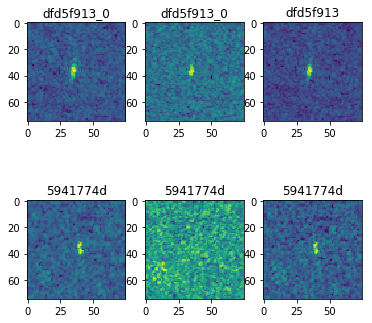

In [16]:
# Preview images
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[0].reshape(75, 75))
ax[0, 0].set_title(id_data[0] + '_' + str(y_data[0]))
ax[0, 1].imshow(band2_data[0].reshape(75, 75))
ax[0, 1].set_title(id_data[0] + '_' + str(y_data[1]))
ax[0, 2].imshow(band_avg_data[0].reshape(75, 75))
ax[0, 2].set_title(id_data[0])

ax[1, 0].imshow(band1_test[0].reshape(75, 75))
ax[1, 0].set_title(id_test[0])
ax[1, 1].imshow(band2_test[0].reshape(75, 75))
ax[1, 1].set_title(id_test[0])
ax[1, 2].imshow(band_avg_test[0].reshape(75, 75))
ax[1, 2].set_title(id_test[0])

**Binarizer**

(75, 75)
Binarizer(copy=True, threshold=-20.655830959107355)
Binarizer(copy=True, threshold=-26.320701804264864)
Binarizer(copy=True, threshold=-23.488266381686106)


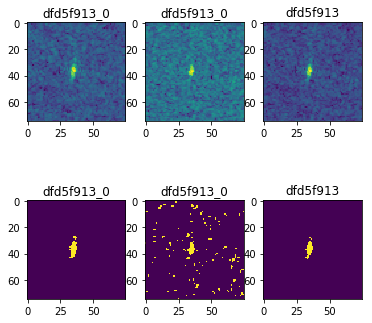

In [17]:
# Preview images
index = 0
print(band1_data[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_data[index].reshape(75, 75))
ax[0, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 1].imshow(band2_data[index].reshape(75, 75))
ax[0, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[0, 2].imshow(band_avg_data[index].reshape(75, 75))
ax[0, 2].set_title(id_data[index])

binarizer1 = Binarizer(copy=True, threshold=im1.mean()).fit(im1)
print(binarizer1)
band1_data_bin = binarizer1.transform(im1)

binarizer2 = Binarizer(copy=True, threshold=im2.mean()).fit(im2)
print(binarizer2)
band2_data_bin = binarizer2.transform(im2)

im_avg = (im1 + im2)/2
binarizer_avg = Binarizer(copy=True, threshold=im_avg.mean()).fit(im_avg)
print(binarizer_avg)
band_data_avg_bin = binarizer_avg.transform(im_avg)

ax[1, 0].imshow(band1_data_bin[index].reshape(75, 75))
ax[1, 0].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 1].imshow(band2_data_bin[index].reshape(75, 75))
ax[1, 1].set_title(id_data[index] + '_' + str(y_data[index]))
ax[1, 2].imshow(band_data_avg_bin[index].reshape(75, 75))
ax[1, 2].set_title(id_data[index])

(75, 75)
Binarizer(copy=True, threshold=-22.44550520353285)
Binarizer(copy=True, threshold=-24.693380698518308)
Binarizer(copy=True, threshold=-23.488266381686106)


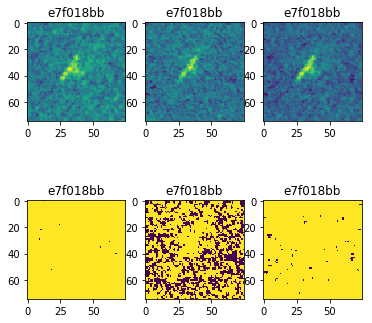

In [18]:
# Preview images
index = 3
print(band1_test[0].shape)
fig, ax = plt.subplots(2, 3, figsize=(6,6))
ax[0, 0].imshow(band1_test[index].reshape(75, 75))
ax[0, 0].set_title(id_test[index])
ax[0, 1].imshow(band2_test[index].reshape(75, 75))
ax[0, 1].set_title(id_test[index])
ax[0, 2].imshow(band_avg_test[index].reshape(75, 75))
ax[0, 2].set_title(id_test[index])

binarizer1 = Binarizer(copy=True, threshold=im1test.mean()).fit(im1test)
print(binarizer1)
band1_test_bin = binarizer1.transform(im1test)

binarizer2 = Binarizer(copy=True, threshold=im2test.mean()).fit(im2test)
print(binarizer2)
band2_test_bin = binarizer2.transform(im2test)

im_test_avg = (im1test + im2test)/2
binarizer_avg = Binarizer(copy=True, threshold=im_avg.mean()).fit(im_test_avg)
print(binarizer_avg)
band_test_avg_bin = binarizer_avg.transform(im_test_avg)

ax[1, 0].imshow(band1_test_bin[index].reshape(75, 75))
ax[1, 0].set_title(id_test[index])
ax[1, 1].imshow(band2_test_bin[index].reshape(75, 75))
ax[1, 1].set_title(id_test[index])
ax[1, 2].imshow(band_test_avg_bin[index].reshape(75, 75))
ax[1, 2].set_title(id_test[index])

**train_test_split**

In [19]:
band1_data_bin_img = band1_data_bin.reshape(-1, 75, 75)
band2_data_bin_img = band2_data_bin.reshape(-1, 75, 75)
band_data_avg_bin_img = band_data_avg_bin.reshape(-1, 75, 75)
band1_test_bin_img = band1_test_bin.reshape(-1, 75, 75)
band2_test_bin_img = band2_test_bin.reshape(-1, 75, 75)
band_test_avg_bin_img = band_test_avg_bin.reshape(-1, 75, 75)
print(band1_data.shape)
print(band1_data_bin.shape)

(1604, 75, 75)
(1604, 5625)


In [20]:
# x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
#                          band2_data[:, :, :, np.newaxis],
#                          band_avg_data[:, :, :, np.newaxis],
#                          band1_data_bin_img[:, :, :, np.newaxis],
#                          band2_data_bin_img[:, :, :, np.newaxis],
#                          band_data_avg_bin_img[:, :, :, np.newaxis]], axis=-1)
# print(x_data.shape)
# x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
#                          band2_test[:, :, :, np.newaxis],
#                          band_avg_test[:, :, :, np.newaxis],
#                          band1_test_bin_img[:, :, :, np.newaxis],
#                          band2_test_bin_img[:, :, :, np.newaxis],
#                          band_test_avg_bin_img[:, :, :, np.newaxis]], axis=-1)
# print(x_test.shape)

In [21]:
x_data = np.concatenate([band1_data[:, :, :, np.newaxis],
                         band2_data[:, :, :, np.newaxis],
                         band_avg_data[:, :, :, np.newaxis]], axis=-1)
print(x_data.shape)
x_test = np.concatenate([band1_test[:, :, :, np.newaxis],
                         band2_test[:, :, :, np.newaxis],
                         band_avg_test[:, :, :, np.newaxis]], axis=-1)
print(x_test.shape)

(1604, 75, 75, 3)
(8424, 75, 75, 3)


In [22]:
x_train, x_val, y_train, y_val = train_test_split(x_data, y_data, test_size=0.15, shuffle=True, random_state=31)
print(x_train.shape)
print(x_val.shape)
print(y_train.shape)
print(y_val.shape)

(1363, 75, 75, 3)
(241, 75, 75, 3)
(1363,)
(241,)


## 2. Build model

In [37]:
from keras.utils.np_utils import to_categorical # convert to one-hot-encoding
from keras.models import Sequential, Model
from keras.layers import Input, Dense, Dropout, Flatten, Conv2D, MaxPool2D, GlobalAveragePooling2D, BatchNormalization
from keras.optimizers import Adam
from keras.preprocessing.image import ImageDataGenerator
from keras.callbacks import LearningRateScheduler, TensorBoard

from keras.applications.vgg19 import VGG19, preprocess_input

In [42]:
def build_model():
    # create the base pre-trained model
    base_model = VGG19(weights='imagenet', include_top=False)

    # add a global spatial average pooling layer
    x = base_model.output
    x = GlobalAveragePooling2D()(x)
    # let's add a fully-connected layer
    x = Dense(1024, activation='relu')(x)
    # and a logistic layer -- let's say we have 200 classes
    predictions = Dense(1, activation='sigmoid')(x)

    # this is the model we will train
    input_1 = Input(shape=(None, 75,75,3))
    model = Model(inputs=input_1, outputs=predictions)

    # first: train only the top layers (which were randomly initialized)
    # i.e. freeze all convolutional InceptionV3 layers
    for layer in base_model.layers:
        layer.trainable = False

    model.compile(optimizer = Adam(lr=1e-4), loss = 'binary_crossentropy', metrics = ['accuracy'])
    return model

In [43]:
model = build_model()
model.summary()

RuntimeError: Graph disconnected: cannot obtain value for tensor Tensor("input_9:0", shape=(?, ?, ?, 3), dtype=float32) at layer "input_9". The following previous layers were accessed without issue: []

In [ ]:
def saveModel(model, run_name):
    cwd = os.getcwd()
    modelPath = os.path.join(cwd, 'model')
    if not os.path.isdir(modelPath):
        os.mkdir(modelPath)
    weigthsFile = os.path.join(modelPath, run_name + '.h5')
    model.save(weigthsFile)
saveModel(model, 'saveModel_test')

In [26]:
annealer = LearningRateScheduler(lambda x: 1e-3 * 0.9 ** x)

log_dir = os.path.join(log_path, run_name)
print('log_dir:' + log_dir)
tensorBoard = TensorBoard(log_dir=log_dir)

log_dir:E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\log\SC_Iceberg_Classifier_CNN_3channel_20171101_214319


In [27]:
hist = model.fit(x_train, y_train, 
                 batch_size = 128, 
                 verbose= 1,
                 epochs = 100, #1 for ETA, 0 for silent
                 validation_data=(x_val, y_val),
                 callbacks=[annealer, tensorBoard])

Train on 1363 samples, validate on 241 samples
Epoch 1/100
1363/1363 [==============================] - 7s - loss: 1.0248 - acc: 0.5979 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 2/100
1363/1363 [==============================] - 2s - loss: 0.5621 - acc: 0.6698 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 3/100
1363/1363 [==============================] - 2s - loss: 0.5371 - acc: 0.7014 - val_loss: 7.0224 - val_acc: 0.5643
Epoch 4/100
1363/1363 [==============================] - 2s - loss: 0.4852 - acc: 0.7483 - val_loss: 6.0376 - val_acc: 0.5602
Epoch 5/100
1363/1363 [==============================] - 3s - loss: 0.4258 - acc: 0.7997 - val_loss: 4.3267 - val_acc: 0.5311
Epoch 6/100
1363/1363 [==============================] - 2s - loss: 0.3965 - acc: 0.8202 - val_loss: 0.8604 - val_acc: 0.4481
Epoch 7/100
1363/1363 [==============================] - 2s - loss: 0.3834 - acc: 0.8305 - val_loss: 0.7979 - val_acc: 0.4938
Epoch 8/100
1363/1363 [==============================] - 2s - loss: 0.3

In [28]:
final_loss, final_acc = model.evaluate(x_val, y_val, verbose=1)
print("Final loss: {0:.4f}, final accuracy: {1:.4f}".format(final_loss, final_acc))

224/241 [==========================>...] - ETA: 0sFinal loss: 0.5858, final accuracy: 0.8299


In [29]:
val_prob1 = model.predict(x_val)

# print('Val log_loss: {}'.format(log_loss(y_val, val_prob1)))
val_prob1_limit = np.clip(val_prob1, 0.00005, 0.99995)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

val_prob1_limit = np.clip(val_prob1_limit, 0.05, 0.95)
loss = log_loss(y_val, val_prob1_limit)
print('Val log_loss: {}'.format(loss))

Val log_loss: 0.5851250498701753
Val log_loss: 0.4376382144531274


In [30]:
final_acc_str = str(int(loss*10000))
run_name_acc = project_name + '_' + step_name + '_' + time_str + '_' + final_acc_str
print(run_name_acc)

SC_Iceberg_Classifier_CNN_3channel_20171101_214319_4376


In [31]:
histories = pd.DataFrame(hist.history)
histories['epoch'] = hist.epoch
print(histories.columns)
histories_file = os.path.join(model_path, run_name_acc + '.csv')
histories.to_csv(histories_file, index=False)

Index(['acc', 'loss', 'val_acc', 'val_loss', 'epoch'], dtype='object')


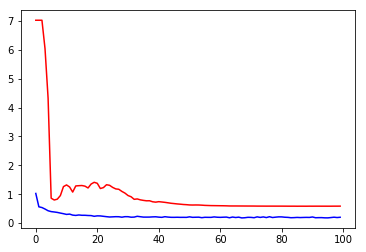

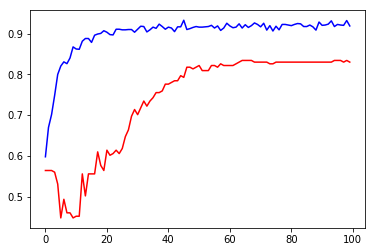

In [32]:
plt.plot(histories['loss'], color='b')
plt.plot(histories['val_loss'], color='r')
plt.show()
plt.plot(histories['acc'], color='b')
plt.plot(histories['val_acc'], color='r')
plt.show()

In [33]:
saveModel(model, run_name_acc)

## 3. Predict

In [34]:
if not os.path.exists(output_path):
    os.mkdir(output_path)
pred_file = os.path.join(output_path, run_name_acc + '.csv')
print(pred_file)

E:\Kaggle\Statoil_C_CORE_Iceberg_Classifier_Challenge\output\SC_Iceberg_Classifier_CNN_3channel_20171101_214319_4376.csv


In [35]:
test_prob = model.predict(x_test)
print(test_prob.shape)
print(test_prob[0:2])
test_prob = np.clip(test_prob, 0.05, 0.95)
print(test_prob.shape)
print(test_prob[0:2])

(8424, 1)
[[ 0.00793453]
 [ 0.67909861]]
(8424, 1)
[[ 0.05      ]
 [ 0.67909861]]


In [36]:
sample_submission['is_iceberg'] = test_prob
print(sample_submission[0:2])
print(sample_submission.shape)
sample_submission.to_csv(pred_file, index=False)

         id  is_iceberg
0  5941774d    0.050000
1  4023181e    0.679099
(8424, 2)


In [37]:
print(run_name_acc)
print('Done!')

SC_Iceberg_Classifier_CNN_3channel_20171101_214319_4376
Done!
